In [ ]:
import cv2
import imutils
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import time
from base64 import b64encode
from IPython.display import Image
from pylab import rcParams
import PIL 
!pip install --upgrade google-api-python-client
from googleapiclient.discovery import build
from google.colab.patches import cv2_imshow
import hashlib
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/Google_Vision_Api_key.json' 
!echo $GOOGLE_APPLICATION_CREDENTIALS
from skimage.measure import compare_ssim as ssim 
!pip install google-cloud-vision
from google.cloud import vision
import skimage

/content/Google_Vision_Api_key.json


In [ ]:
import getpass

APIKEY = getpass.getpass()

··········


In [ ]:
def makeData(img_path):
  #path of document image 
  img_req = None 
  with open(img_path,"rb") as f:
    content = b64encode(f.read()).decode()
    img_req = {
        "image":{
            "content":content,
        },
        "features":[{
            "type":"TEXT_DETECTION",
            "max_results":1
        }]
    }
  return json.dumps({"requests":img_req}).encode()

In [ ]:
def requestOCR(url, imgpath):
  imgdata = makeData(imgpath)
  response = requests.post(ENDPOINT_URL, 
                           data = imgdata, 
                           params = {'key': APIKEY}, 
                           headers = {'Content-Type': 'application/json'})
  return response

In [ ]:
ENDPOINT_URL = 'https://vision.googleapis.com/v1/images:annotate'
img_loc = "/content/sample-adhaar-short-card-rotated.png"
#img_loc denoted location of document image 

In [ ]:
def get_resized_image(img_locat,size):
  img = cv2.imread(img_locat)
  img = cv2.resize(img,size)
  cv2.imwrite(img_locat,img)
  img = cv2.imread(img_locat)
  return img 

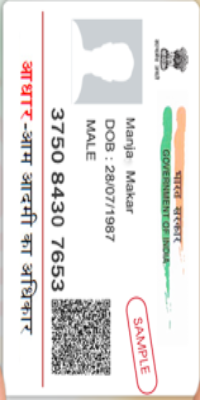

In [ ]:
img = get_resized_image(img_loc,(200,400))
cv2_imshow(img)

In [ ]:
result = requestOCR(ENDPOINT_URL,img_loc)

In [ ]:
if result.status_code != 200 or result.json().get('error'):
    print(result.status_code)
    print ("Error")
else:
    result = result.json()#['responses'][0]['textAnnotations']

In [ ]:
print(result)

{'responses': [{'textAnnotations': [{'locale': 'hi', 'description': 'भारत सरकार\nGOVERNMENTOFINDIA\nSAMPLE\nManja Makar\nDOB : 28/07/1987\nMALE\n3750 8430 7653\nआधार-आम आदमी का अधिकार\n', 'boundingPoly': {'vertices': [{'x': 18, 'y': 61}, {'x': 180, 'y': 61}, {'x': 180, 'y': 374}, {'x': 18, 'y': 374}]}}, {'description': 'भारत', 'boundingPoly': {'vertices': [{'x': 181, 'y': 170}, {'x': 181, 'y': 198}, {'x': 174, 'y': 198}, {'x': 174, 'y': 170}]}}, {'description': 'सरकार', 'boundingPoly': {'vertices': [{'x': 181, 'y': 206}, {'x': 181, 'y': 242}, {'x': 174, 'y': 242}, {'x': 174, 'y': 206}]}}, {'description': 'GOVERNMENTOFINDIA', 'boundingPoly': {'vertices': [{'x': 172, 'y': 147}, {'x': 172, 'y': 266}, {'x': 161, 'y': 266}, {'x': 161, 'y': 147}]}}, {'description': 'SAMPLE', 'boundingPoly': {'vertices': [{'x': 141, 'y': 318}, {'x': 149, 'y': 372}, {'x': 141, 'y': 374}, {'x': 133, 'y': 319}]}}, {'description': 'Manja', 'boundingPoly': {'vertices': [{'x': 134, 'y': 118}, {'x': 134, 'y': 157}, 

In [ ]:
result["responses"][0]['textAnnotations'][0]["description"].split("\n")

['भारत सरकार',
 'GOVERNMENTOFINDIA',
 'SAMPLE',
 'Manja Makar',
 'DOB : 28/07/1987',
 'MALE',
 '3750 8430 7653',
 'आधार-आम आदमी का अधिकार',
 '']

In [ ]:
class Verification:
  def PAN_verification(self,user_data,result):
    keys = ["Permanent Account Number Card","नाम/ Name","पिता का नाम / Father's Name","Date of Birth"]
    flag = True 
    for i in range(len(result)):
      if result[i] in keys:
        if result[i+1]!=user_data[result[i]]:
          print(result[i])
          flag = False 
          break 
    if flag:
      return "Successfully Verified!"
    return "Verification Failed!"
  def Adhaar_verification(self,user_data,result):
    result.remove("SAMPLE")
    flag = True
    if result[2]!=user_data["Name"]:
      flag = False 
    if result[3].split(":")[1].strip()!=user_data["DOB"]:
      flag = False 
    if result[4]!=user_data["Gender"]:
      flag = False 
    if result[5]!=user_data["Adhaar_number"]:
      flag = False 
    if flag:
      return "Successfully Verified!"
    return "Verification Failed!"

In [ ]:
Sample = Verification()
user_data_pan = {"Permanent Account Number Card":"ABCDE1234G",
             "नाम/ Name":"APPLICANT NAME",
             "पिता का नाम / Father's Name":"APPLICANT'S FATHER NAME",
             "Date of Birth":"01/06/1995",
             }
print(Sample.PAN_verification(user_data_pan,result["responses"][0]['textAnnotations'][0]["description"].split("\n")))

Successfully Verified!


In [ ]:
Sample = Verification()
user_data_adhaar = {"Name":"Manja Makar",
                    "DOB":"28/07/1987",
                    "Gender":"MALE",
                    "Adhaar_number":"3750 8430 7653"}
print(Sample.Adhaar_verification(user_data_adhaar,result["responses"][0]['textAnnotations'][0]["description"].split("\n")))

Successfully Verified!


In [ ]:
#Improving Service by allowing one time documents upload and verification and optimizing storage using cryptography

In [ ]:
def hash_doc(documents):
  unique_docs = {}
  for doc,path in documents.items():
    with open(path,"rb") as f:
      content = f.read()
      hash_function = hashlib.sha512()
      hash_function.update(content)
      unique_docs[doc] = hash_function.hexdigest()
  return unique_docs

In [ ]:
documents = {"Aadhar_card":"/content/aadharcardsample.jpg",
             "Pan_card":"/content/sample-pan-card.jpg"}
unique_docs = hash_doc(documents)
for key,value in unique_docs.items():
  print("{}  ===>  {}".format(key,value))

Aadhar_card  ===>  5ad06fa3672e7ba9199cb3e70a0cab764c53377f3aef28ed9f6c46aadfd7c5ca3f19c0807474eaec824b7d1216e3500ecfb992f934e419b6dd3bba6053d8b345
Pan_card  ===>  cf9130a173ee92540624cfd4b776dfa70fce8aa482b21263c40a564d0f1cb4dd16226e0ce32cbb57552e0ef880bd973c4646311bd32c3cb8b10d4405b51db147


In [ ]:
def detect_face(face_file, max_results=1):
    client = vision.ImageAnnotatorClient()

    with open(face_file,"rb") as f:
      content = f.read()
    image = vision.Image(content=content)
    return client.face_detection(
        image=image, max_results=max_results).face_annotations

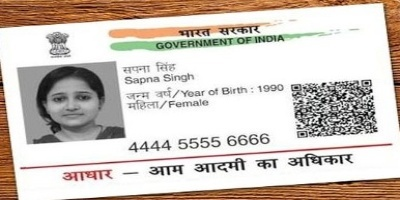

In [ ]:
photo_img_doc = "/content/sample2_orig.jpg"
image = cv2.imread(photo_img_doc)
cv2_imshow(image)
response = detect_face(photo_img_doc)

In [ ]:
def extract_image(result,image):
  face = response[0]
  x1 = face.bounding_poly.vertices[0].x 
  x2 = face.bounding_poly.vertices[1].x
  y1 = face.bounding_poly.vertices[0].y
  y2 = face.bounding_poly.vertices[2].y
  return image[y1:y2,x1:x2]

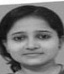

In [ ]:
extracted_image = extract_image(response,image)
cv2_imshow(extracted_image)

In [ ]:
def validate_image(passport_photo,extracted_img):
  threshold = 0.75
  metric_value = skimage.metrics.structural_similarity(passport_photo,extracted_image, multichannel = True)
  if metric_value>=threshold:
    return "Photo Successfully Verified!"
  else:
    return "Photo Verification Failed!"

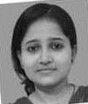

In [ ]:
photo_image = cv2.imread("/content/photo-img.jpg")
cv2_imshow(photo_image)

In [ ]:
print(validate_image(extracted_image,photo_image))

Photo Successfully Verified!
